In [17]:
'''
Hi Chuong,

kurze Erklärung zu diesem Notebook:

Dient zum  Aufteilen der parquet-Files in Abschnitte. Es werden Keine Signale entfernt oder Werte verändert, sondern nur
die einzelnen DataFrames in mehrere neue aufgespalten und mit fortlaufender Nummerierung (z.B. "V101_T16.parquet") abgespeichert. Output am
besten in Neuen Ordner verlegen. Alte Dateien werden nicht verändert.

    Zelle 3: Pfade eintragen, wo die parquet-Dateien liegen und wo ggf. neue Dateien gespeichert werden sollen 
    Zelle 6: War für mein Preprocessing notwendig, um Signale auzuwählen. kann hier ignoriert werden

    Hauptteil in Zelle 9:
        - einfach mal ausprobieren ob es funktioniert (Zelle wiederholen für neues Beispiel)
        - Diagramm unten veranschaulicht die ausgewählten Sequenzen
        - Für das Bearbeiten und speichern aller Dateien, setze save = True, plot = False und sample_only = False
        - Zeilen 141 bis 156, um die wesentlichen Anforderungen festzulegen

    Zelle 10: zeigt die Abschnitte aus Zelle 9 nochmals im Detail

Ich hoffe, das hilft dir weiter!
VG William
''';

In [18]:
#%reset -f 
import sys, os, pickle, random
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

from datetime import datetime
from pathlib import Path
from scipy.signal import savgol_filter
from scipy.stats import zscore, median_abs_deviation
from itertools import groupby

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell): return  # cells can be skipped by using '%%skip' in the first line

In [19]:
# -----------> SET DATA FOLDER LOCATION HERE:
DATA_PATH = Path('home', 'sieglew', 'MA-Data')

# FILE SOURCES ---------------------------------------------------------------
original_trips_folder = Path(DATA_PATH, "processed") # original Trip parquet files

# OUTPUT LOCATIONS ---------------------------------------------------------------
trips_processed_final = Path(DATA_PATH, "new_folder") # Save new files here

In [20]:
# GET DIRECTORY CONTENTS:
def get_files(folder, ext, full = False): return [file if full else file.name for file in folder.glob(f'*{ext}')]
trips = get_files(original_trips_folder, ".parquet", full = False)
len(trips)

0

In [21]:
# get list of signals
df = pd.read_parquet(Path(original_trips_folder, trips[0]), engine='fastparquet')
all_columns = df.columns
assert len(all_columns) == 114

IndexError: list index out of range

In [ ]:
# SUMMARY OF ANALYSIS: 
#############################################################################################################################################
# SIGNALS  ###################################################################################################
# these signals always have more than 90% nans and will be removed from all trips:
sparse_signals = {'odometer','signal_date','vehicle_id', 'diff',
                  'chrgcoupproxydet_stat','hv_batmaxdischrgpwrlim_cval', 'hv_ptc2_pwr_cval',
                  'inv1_curr_cval_api1','inv1_pwr_cval_api1','inv1_pwr_cval_api3','inv1_spd_cval_api1','inv2_curr_cval_api2','inv2_pwr_cval_api2', 'inv2_spd_cval_api2'}

# these signals are either all-nans in a significant amount of trips or are too redundant/insignificant and will thus be removed from all trips:
remove_signals = {"minmoduletempindex_bms01", "maxmoduletempindex_bms01", "brc_stat_brc2", "maxpwr_contendrnbrkresist2","currtmp_brkresist2int_cval", "currpwr_contendrnbrkresist2",
                  "plugchrg_stat", "hv_chrgpwr_ecpc_cval", "chargestate", "dsrdpwr_contendrn_cval", "dsrdpwr_contendrn2_cval","maproadgrad_cval", "airtempoutsd_cval_sca", 
                  "meanmoduletemperature_bms01", "linkvoltage_bms05", "lv_conv_voltdmd_e2e_dcl1", "lv_convmaxcurr_cval_dcl1", "lv_convcurr_cval_dcl1","lv_conv_dc_momvolt_cval_dcl1", 
                  "hv_batlinkvoltage_sc01", "hv_dclink_volt_cval_brc", "hv_dclink_volt_cval_brc2", "oiltemp_ra_cval","hv_bat_intres_cval_bms1", "stringvoltage_bms01", 
                  "currtmp_brkresist1int_cval", "maxpwr_contendrnbrkresist_cval", "hv_bat_dc_volt_cval_bms1", "pt4_dcb_temp2_st3", "pt4_dcb_temp1_st3", "maxbrickvoltage_bms01",
                  'cc_actv_stat', 'cc_setspd_cval', 'pt4_dcb_hvdc_power_max_st3', 'hv_bathighcelltemp_cval_bms1', 'hv_batlowcelltemp_cval_bms1', 'hv_batmomavlchrgen_cval_bms1', 
                  'signal_ts', 'hv_bat_soh_cval_bms1', 'grocmbvehweight_cval'}

# these signals are either identical or too correlated with one of the other signals and will be removed from all trips:
redundant_signals = {'hirestotalvehdist_cval_cpc', 'ambtemp_cval_pt', 'grshift_stat_pt', 'currgr_stat_edcu', 'edrvspd_cval', 'hv_bat_dc_maxvoltlim_cval',
                     'hv_bat_dc_minvoltlim_cval', 'ignsw_stat_sca'}
                     
drop_signals = list(sparse_signals | remove_signals | redundant_signals)

# interrelated signal pairs can be combined (mean with nans ignored) to only introduce one variable:
pair_signals = [('actualdcvoltage_pti1', 'actualdcvoltage_pti2'), # only the first variable of each pair will be kept
                ('actualspeed_pti1', 'actualspeed_pti2'), 
                ('actualtorque_pti1','actualtorque_pti2'),
                ('motortemperature_pti1','motortemperature_pti2'),
                ('powerstagetemperature_pti1', 'powerstagetemperature_pti2'),
                ('rmsmotorcurrent_pti1','rmsmotorcurrent_pti2'),
                ('brktempra_cval', 'brktempfa_cval'),
                ('roadgrad_cval_pt','bs_roadincln_cval')]

# these signals should be explicitly considered for outlier removal to clean and improve data quality
signal_remove_outliers = ["roadgrad_cval_pt","hirestotalvehdist_cval_icuc","vehspd_cval_cpc", 
                        "hv_batmomavldischrgen_cval_1", "hv_bat_soc_cval_bms1", "airtempinsd_cval_hvac", "airtempoutsd_cval_cpc","hv_bathighcelltemp_cval_bms1",
                        "hv_batlowcelltemp_cval_bms1", "hv_dclink_volt_cval_dcl1", "actualdcvoltage_pti1", "hv_bat_dc_momvolt_cval_bms1","hv_batmaxchrgpwrlim_cval_1", 
                        "hv_batmaxdischrgpwrlim_cval_1"]

# optional signals
# could be kept and filled with zeros/ones instead, to retain the ePTO feature if available in the truck
optional_or_zero = ['epto_pwr_cval', 'currpwr_contendrnbrkresist_cval', 'elcomp_pwrcons_cval'] # --> fill with: "0" if not available
optional_or_one = ['brc_stat_brc1'] #--> fill with "1" if not available

# FILES  ###################################################################################################
# these trips do not contain valid trips or are too short or are sorted out for other reasons
invalid_original_trips = ['v_id983V101_trip30.parquet', 'v_id983V101_trip70.parquet', 'v_id983V101_trip8.parquet', 'v_id983V101_trip94_2.parquet', 'v_id983V10_trip19.parquet', 
                           'v_id983V10_trip22.parquet', 'v_id983V10_trip32.parquet', 'v_id983V10_trip36.parquet', 'v_id983V13_trip199.parquet', 'v_id983V14_trip9.parquet', 
                           'v_id983V15_trip70.parquet', 'v_id983V16_trip1.parquet', 'v_id983V16_trip178.parquet', 'v_id983V16_trip185.parquet', 'v_id983V16_trip197.parquet', 
                           'v_id983V16_trip2.parquet', 'v_id983V17_trip132.parquet', 'v_id983V18_trip198.parquet', 'v_id983V18_trip2.parquet', 'v_id983V18_trip218.parquet', 
                           'v_id983V18_trip6.parquet', 'v_id983V19_trip111.parquet', 'v_id983V19_trip113.parquet', 'v_id983V19_trip87.parquet', 'v_id983V19_trip99.parquet', 
                           'v_id983V1_trip100.parquet', 'v_id983V1_trip109.parquet', 'v_id983V1_trip116.parquet', 'v_id983V1_trip117.parquet', 'v_id983V1_trip118.parquet', 
                           'v_id983V1_trip13.parquet', 'v_id983V1_trip132.parquet', 'v_id983V1_trip142.parquet', 'v_id983V1_trip162.parquet', 'v_id983V1_trip163.parquet', 
                           'v_id983V1_trip26.parquet', 'v_id983V1_trip31.parquet', 'v_id983V1_trip40.parquet', 'v_id983V1_trip41.parquet', 'v_id983V1_trip43.parquet', 
                           'v_id983V1_trip44.parquet', 'v_id983V1_trip46.parquet', 'v_id983V1_trip54.parquet', 'v_id983V1_trip6.parquet', 'v_id983V2_trip60.parquet', 
                           'v_id983V4_trip139.parquet', 'v_id983V4_trip36.parquet', 'v_id983V4_trip58.parquet', 'v_id983V1_trip118.parquet', 'v_id983V1_trip132.parquet', 
                           'v_id983V14_trip9.parquet', 'v_id983V10_trip19.parquet', 'v_id983V17_trip132.parquet', 'v_id983V1_trip163.parquet', 'v_id983V1_trip132.parquet', 
                           'v_id983V10_trip19.parquet', 'v_id983V1_trip163.parquet', 'v_id983V1_trip132.parquet', 'v_id983V1_trip163.parquet', 'v_id983V19_trip87.parquet', 
                           'v_id983V1_trip163.parquet']

In [ ]:
trips = [_ for _ in trips if _ not in invalid_original_trips]
print('Keep no. trips: ', len(trips))

keep_signals = [col for col in all_columns if col not in drop_signals + [b for _, b in pair_signals]]
print('Keep no. signals: ', len(keep_signals))

Keep no. trips:  3149
Keep no. signals:  44


In [ ]:
# UTILS
####################################################################################################
def expand_indices(r_list, ws, offset, max_val):
    r_set = set(r_list).copy()
    for i in range(-ws,ws+1):
        r_set = r_set | set([x+i for x in r_list])
    r_set = [x+offset for x in list(r_set)]
    drops = [x for x in list(r_set) if (x>=0 and x<max_val)]
    return sorted(drops)

####################################################################################################   
def smooth_filter(X, ws, remove_outliers = True, smooth = True):

    def custom_filter(X,ws, remove_outliers, thresh = 8):
        X_filtered = X.copy()
        X_noise  = abs(zscore(X.ffill().bfill() - savgol_filter(X.ffill().bfill(), ws,1, mode='nearest'), nan_policy='omit'))
        if remove_outliers:
            cr = X.std() - median_abs_deviation(X, nan_policy='omit')
            thresh_new = max(abs(X.std() / cr), thresh) if cr != 0 else max(abs(X.std()), thresh)
            peaks = expand_indices(list(np.where((X_noise > thresh_new))[0]), int(ws), 0, len(X))
            X_filtered[peaks] = np.nan
            X_filtered[X_noise.isna()] = np.nan
        else:
            thresh_new = None

        if X_filtered.nunique() < 2:
            X_filtered.fillna(X_filtered.mean(), inplace=True)
        else:
            X_filtered.ffill(inplace=True)
            X_filtered.bfill(inplace=True)  

        return X_filtered, X_noise, thresh_new

    X_filtered, X_noise, thresh = custom_filter(X, ws, remove_outliers = remove_outliers)
    
    if (X - X_filtered).std() > 10:
        X_filtered, X_noise, thresh = custom_filter(X_filtered, ws, remove_outliers = remove_outliers)

    if smooth: X_filtered = savgol_filter(X_filtered, ws/2,1, mode='nearest')
    return X_filtered, X_noise, thresh

####################################################################################################
def get_slices(c_state, min_length=60, exp=lambda val: val == 0):
        slices = []
        start = None
        for i, val in enumerate(c_state):
            condition = exp(val)
            if condition and start is None:
                    start = i
            elif not condition and start is not None:
                    if (i - start) >= min_length:
                        slices.append(slice(start, i))
                    start = None
        if start is not None and (len(c_state) - start) >= min_length:
            slices.append(slice(start, len(c_state)))
        return slices

####################################################################################################
def intersect_slices(slices_A, slices_B):
    intersection_slices = []
    for v_slice in slices_A:
        for c_slice in slices_B:
            start = max(v_slice.start, c_slice.start)
            stop = min(v_slice.stop, c_slice.stop)
            if start < stop:
                intersection_slices.append(slice(start, stop))
    return intersection_slices

####################################################################################################
def split_dataframe_by_slices(df, slices):
    return [df.iloc[s] for s in slices]

####################################################################################################
idx_dict = {}
def save_dataframes_to_parquet(dataframes, base_path, idx_dict, veh_id):
    if f"{veh_id}" not in idx_dict: idx_dict[f"{veh_id}"] = 0
    start_idx = idx_dict[f"{veh_id}"]+1
    new_files = []
    for i, df in enumerate(dataframes):
        filename = f"V{veh_id}_T{i+start_idx}.parquet"
        new_files.append(filename)
        df.to_parquet(Path(base_path, filename), engine='fastparquet')
    idx_dict[f"{veh_id}"] = start_idx + i
    return new_files, idx_dict

####################################################################################################
def find_nan_sections(series):
    nan_sections = []
    start_idx = None

    for idx, value in series.isna().items():
        if value and start_idx is None:
            start_idx = idx
        elif not value and start_idx is not None:
            if idx > start_idx + 2:
                nan_sections.append(start_idx)
            start_idx = None

    if start_idx is not None:
        nan_sections.append(start_idx)

    # Remove neighboring numbers
    nan_sections = [nan_sections[i] for i in range(len(nan_sections)) if i == 0 or nan_sections[i] != nan_sections[i-1] + 1]

    return nan_sections

In [ ]:
# SECTIONING OF TRIPS
# -----------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------
# Note: 
    # for experimental purposes: save = False, plot = True, sample_only = True (REPEAT CELL FOR NEW SAMPLE)
    # for final processing: save = True, plot = False, sample_only = False
save = True
plot = False
sample_only = False

# -----------------------------------------------------------------------------------------------
empty_files = []        # collect parquet files without valid sections found
nan_table = []          # summarize nan percentages

# -----------------------------------------------------------------------------------------------
for n, f in enumerate(random.sample(trips, 1) if sample_only else trips):

    if not sample_only and plot: 
        print("disable 'plot'!")
        break

    # READ FILE ---------------------------------------------------------------
    #f = "v_id983V17_trip195.parquet"
    print(f"{n}: {f}"); vehicle_id = f[8:11].strip("_t"); file_code = f[7:-8]; prefix = f[:7]
    print(f"\tVehicle ID: {vehicle_id}, File Code: {file_code}, Prefix: {prefix}")

    df = pd.read_parquet(Path(original_trips_folder, f), engine='fastparquet')
    df.sort_index(axis=1, inplace=True)
    # df.reset_index(drop=True, inplace=True)
    
    # SIGNALS ---------------------------------------------------------------
    # assign important signals to variables
    alt, lat, ign = df["altitude_cval_ippc"], df["latitude_cval_ippc"], df["ignsw_stat_sca"]
    dist, v, en = df["hirestotalvehdist_cval_icuc"], df["vehspd_cval_cpc"], df["hv_batmomavldischrgen_cval_1"]
    soc, emot, maxrecup = df["hv_bat_soc_cval_bms1"], df["emot_pwr_cval"], df["maxrecuppwrprc_cval"]
    c_state = df["plugchrg_stat"].where(df["plugchrg_stat"].isin([0, 1])).ffill().bfill()

    # first derivative of certain signals to indicate significant jumps
    alt_diff = pd.DataFrame(abs(np.diff(alt.ffill().bfill())))
    lat_diff = pd.DataFrame(abs(np.diff(lat.ffill().bfill())))
    en_diff = pd.DataFrame(abs(zscore(np.diff(en.ffill().bfill()), nan_policy='omit')))
    ign_diff = pd.DataFrame(abs(zscore(np.diff(ign.ffill().bfill()), nan_policy='omit')))

    # TENTATIVE SPLITTING MARKS ---------------------------------------------------------------
    # Combine split indices from different conditions
    split_indices = alt_diff[alt_diff[0] > 50].index.union(
                    lat_diff[lat_diff[0] > 10].index).union(
                    en_diff[en_diff[0] > 15].index).union(
                    ign_diff[ign_diff[0] > 20].index)

    split_indices = split_indices.union(find_nan_sections(en))
    # if split_indices.empty: continue

    # TENTAIVE SLICING BASED ON CHARGING STATUS AND SPEED SIGNALS -----------------------------
    # obtain slices from charging status and speed signal -------------------------------------
    c_slices = get_slices(c_state)

    v_filtered = v.rolling(window=80, min_periods=1).mean()
    v_sections = get_slices(v_filtered, min_length=120, exp = lambda val: val > 0)

    # Merge sections if they are separated by less than merge_threshold
    v_slices = []
    merge_threshold = 60
    for i, section in enumerate(v_sections):
        merge_threshold += abs((section.stop - section.start))/2
        merge_threshold = min(merge_threshold, 6*60)	
        #print(merge_threshold)
        if v_slices and section.start - v_slices[-1].stop < merge_threshold:
            v_slices[-1] = slice(v_slices[-1].start, section.stop)
        else:
            v_slices.append(section)
    
    # merge sections from v_slices and c_slices
    sections = intersect_slices(v_slices, c_slices)


    # PROCESSING OF OBTAINED SECTIONS AND SPLIT MARKS ---------------------------------------------------------------
    # ---------------------------------------------------------------------------------------------------------------
    # remove overlapping slices ---------------------------------------------------------------
    for i, s1 in enumerate(sections):
        for j, s2 in enumerate(sections):
            if i != j:
                start = max(s1.start, s2.start)
                stop = min(s1.stop, s2.stop)
                if start < stop:
                    print(f"Intersection found between section {i} and section {j}: {slice(start, stop)}")
                    if s1.stop - start < stop - s2.start:
                        sections[i] = slice(s1.start, start)
                    else:
                        sections[j] = slice(stop, s2.stop)
                    print(f"Section overlaps removed.")
  
    # SPLIT SECTIONS BASED ON ENERGY DIFFERENCE THRESHOLD ------------------------------
    #if split_indices is not None: print(f"Split indices: {split_indices}")
    for split_idx in split_indices:
        for i, s in enumerate(sections):
            if s.start < split_idx < s.stop:
                sections[i] = slice(s.start, split_idx)
                sections.insert(i + 1, slice(split_idx, s.stop))

    # SPLIT SECTIONS BASED ON VEHICLE SPEED BREAKS -------------------------------------
    for i, s in enumerate(sections):
        if (((v[section] == 0).mean()>0.5 or v[section].isna().mean()>0.5) and (s.stop-s.start) > 4*60) \
            or (((v[section] == 0).mean()>0.2 or v[section].isna().mean()>0.2) and (s.stop-s.start) > 20*60):
            invalid_indices = v[s][(v[s] == 0) | (v[s].isna())].index
            if len(invalid_indices) > 0:
                longest_inv_seq = max((list(g) for _, g in groupby(enumerate(invalid_indices), lambda ix: ix[0] - ix[1])), key=len)
                first_index = longest_inv_seq[0][1]
                last_index = longest_inv_seq[-1][1]
                if last_index - first_index > 2*60:
                    sections[i] = slice(s.start, first_index)
                    sections.insert(i + 1, slice(last_index, s.stop))

    # remove trailing zeros and nans ---------------------------------------------------------------
    for i, s in enumerate(sections):
        if s.stop < len(v)-1:
            if len(v[s]) > 0:
                if v[s].iloc[-1] == 0 or pd.isna(v[s].iloc[-1]):
                    if v[s][v[s] != 0].last_valid_index() is not None:
                        sections[i] = slice(s.start, v[s][v[s] != 0].last_valid_index()+2)
                elif v[s].last_valid_index() is not None:
                    if v[v[s].last_valid_index()+1] == 0:
                        sections[i] = slice(s.start, v[s].last_valid_index()+2)
        elif v[s].iloc[-1] == 0 or pd.isna(v[s].iloc[-1]):
            if v[s][v[s] != 0].last_valid_index() is not None:
                try:
                    sections[i] = slice(s.start, v[s][v[s] != 0].last_valid_index()+2)
                except:
                    sections[i] = slice(s.start, v[s][v[s] != 0].last_valid_index()+1)

    # remove leading zeros and nans ---------------------------------------------------------------
    for i, s in enumerate(sections):  
        if v[s][v[s] != 0].first_valid_index() is not None:
            if s.start > 0  and v[v[s].first_valid_index()-1] == 0:        
                sections[i] = slice(v[s][v[s] != 0].first_valid_index()-1, s.stop)
            else:
                sections[i] = slice(v[s][v[s] != 0].first_valid_index(), s.stop)

    # FINAL CHECK OF FOUND SECTIONS, BASED ON CRITERIA ---------------------------------------------------------------
    # discard sections that are either too short or too slow or have too many target nans ----------------------------
    sections = [_ for _ in sections \
            # MIN SECTION LENGTH: 120 seconds
                if (_.stop - _.start) >= 60 \
            # MIN AVERAGE SPEED: 3 km/h          
                and v[_.start:_.stop].mean() > 3 \
            # MIN TOP SPEED: 5 km/h
                and v[_.start:_.stop].max() > 5 \
            # MAX STANDING (SPEED=0) PERCENTAGE: 60%
                and (v[_.start:_.stop] == 0).mean() < 0.6 \
            # MAX NAN PERCENTAGE (SPEED): 20%   
                and v[_.start:_.stop].isna().mean() < 0.2\
            # MAX NAN PERCENTAGE (EN): 20% 
                and en[_.start:_.stop].isna().mean() < 0.2 \
            # MIN NUMBER OF UNIQUE EN VALUES: 5
                and en[_.start:_.stop].nunique() > 5
                ]

    # OUTPUT INFO ON FINAL SECTIONS ---------------------------------------------------------------
    for i, section in enumerate(sections):
        print(f"\t\tSection {i} from {section.start} to {section.stop}, length: {section.stop - section.start}, mean speed: {v[section.start:section.stop].mean():.2f}")

    # VISUALIZATION ---------------------------------------------------------------
    if plot:
        fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(18, 24), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1, 1, 1, 1, 1, 1.5]})
        # ---------------------------------------------------------------
        ax = axes[0]
        en.plot(ax=ax, title="Battery Energy")
        for idx in split_indices: ax.axvline(x=idx, color='r', linestyle='--')
        handle = plt.Line2D([0], [0], color='r', linestyle='--')
        ax.legend(labels=['hv_batmomavldischrgen_cval_1 [kWh]', 'Section Marks'])
        # ---------------------------------------------------------------
        ax = axes[1]
        alt.plot(ax=ax, title="Altitude Profile", color='g')
        ax.legend(labels=['altitude_cval_ippc [m]'])
        for idx in split_indices: ax.axvline(x=idx, color='r', linestyle='--')
        # ---------------------------------------------------------------
        ax = axes[2]
        ign.plot(ax=ax, title="Ignition Status", color='k')
        ax.legend(labels=['ignsw_stat_sca (filtered)'])
        for idx in split_indices: ax.axvline(x=idx, color='r', linestyle='--')
        # ---------------------------------------------------------------
        ax=axes[3]
        c_state.plot(ax=ax, color='r', title="Charging Status")
        for section in c_slices: ax.axvspan(section.start, section.stop, color='red', alpha=0.3)
        ax.legend(labels=['plugchrg_stat (filtered, cleaned)', 'Valid Sections'])
        # ---------------------------------------------------------------
        ax=axes[4]
        pd.DataFrame((emot < 0).astype(int)).plot(ax=ax, color='r')
        pd.DataFrame(maxrecup/max(maxrecup)).plot(ax=ax, color='g', title="E-Motor Recuperation", linewidth=2)
        ax.legend(labels=['emot_pwr_cval (negative only)', 'maxrecuppwrprc_cval (normalized)'])
        # ---------------------------------------------------------------
        ax=axes[5]
        v.plot(ax=ax, color='b', title="Vehicle Speed")
        for section in v_slices: ax.axvspan(section.start, section.stop, color='b', alpha=0.3)
        ax.legend(labels=['vehspd_cval_cpc [km/h]', 'Valid Sections'])
        # ---------------------------------------------------------------
        ax=axes[6]
        pd.DataFrame(np.diff(dist)*3600).plot(ax=ax, color='b')
        v_filtered.plot(ax=ax, color='r')
        ax.legend(labels=['dist_diff [km/h]', 'vehspd_cval_cpc (moving average)'])
        # ---------------------------------------------------------------
        ax=axes[7]
        v.plot(ax=ax, color='b')
        soc.plot(ax=ax, color='g')
        ax.set_title("RESULTS: FINAL SECTIONS", fontweight='bold')
        for section in sections:
            ax.axvspan(section.start, section.stop, color='red', alpha=0.4)
            ax.axvline(x=section.start, color='k', linestyle=':')
            ax.axvline(x=section.stop, color='k', linestyle=':')
        ax.legend(labels=['vehspd_cval_cpc [km/h]', 'hv_bat_soc_cval_bms1 [%]', 'Final Sections'])
        # ---------------------------------------------------------------
        plt.show()

    # SAVE ---------------------------------------------------------------
    if not sections: 
        print(f"------> No valid sections found in {f}\n{'-'*120}\n")
        empty_files.append(f)
    else:
        if save:
            sliced_sections = split_dataframe_by_slices(df, sections)
            saved_sections, idx_dict = save_dataframes_to_parquet(sliced_sections, trips_processed_final, idx_dict, vehicle_id)
            print(f"\t{len(saved_sections)} sections found.")
            print(f"\t\t{saved_sections}, veh_idx: {idx_dict}")
            for i, sliced_section in enumerate(sliced_sections):
                nan_percentage = sliced_section.isna().mean() * 100
                nan_table.append((f, saved_sections[i], nan_percentage))

0: v_id983V101_trip1.parquet
	Vehicle ID: 101, File Code: V101_trip1, Prefix: v_id983
		Section 0 from 136 to 7207, length: 7071, mean speed: 56.07
		Section 1 from 7452 to 7801, length: 349, mean speed: 25.33
	2 sections found.
		['V101_T1.parquet', 'V101_T2.parquet'], veh_idx: {'101': 2}
1: v_id983V101_trip10.parquet
	Vehicle ID: 101, File Code: V101_trip10, Prefix: v_id983
		Section 0 from 2632 to 3452, length: 820, mean speed: 10.96
		Section 1 from 4569 to 4665, length: 96, mean speed: 21.39
		Section 2 from 5805 to 6052, length: 247, mean speed: 30.63
		Section 3 from 8297 to 8703, length: 406, mean speed: 25.38
		Section 4 from 9152 to 9235, length: 83, mean speed: 8.71
		Section 5 from 9843 to 10730, length: 887, mean speed: 18.73
		Section 6 from 10730 to 11945, length: 1215, mean speed: 36.44
		Section 7 from 12139 to 14270, length: 2131, mean speed: 27.24
		Section 8 from 14688 to 14869, length: 181, mean speed: 12.47
	9 sections found.
		['V101_T3.parquet', 'V101_T4.parquet

KeyboardInterrupt: 

section 0
length: 885
speed (start, end): (81.996875, 0.0)


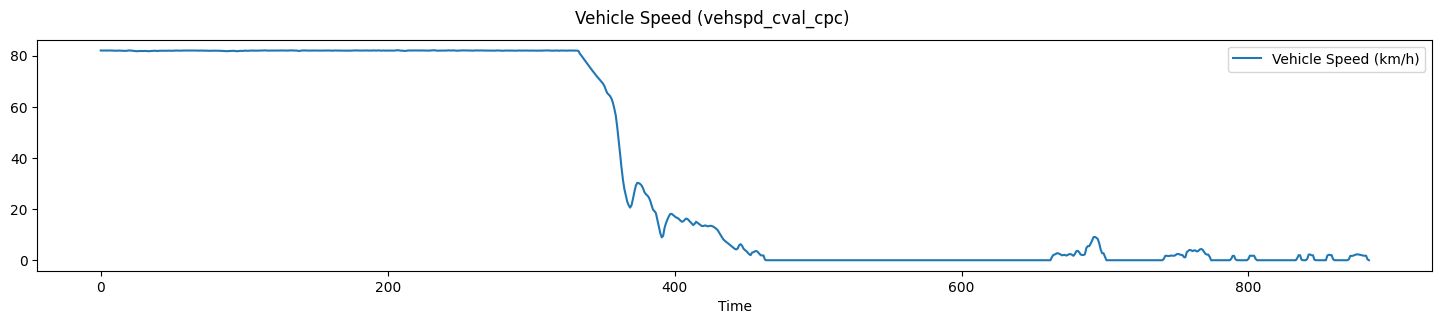

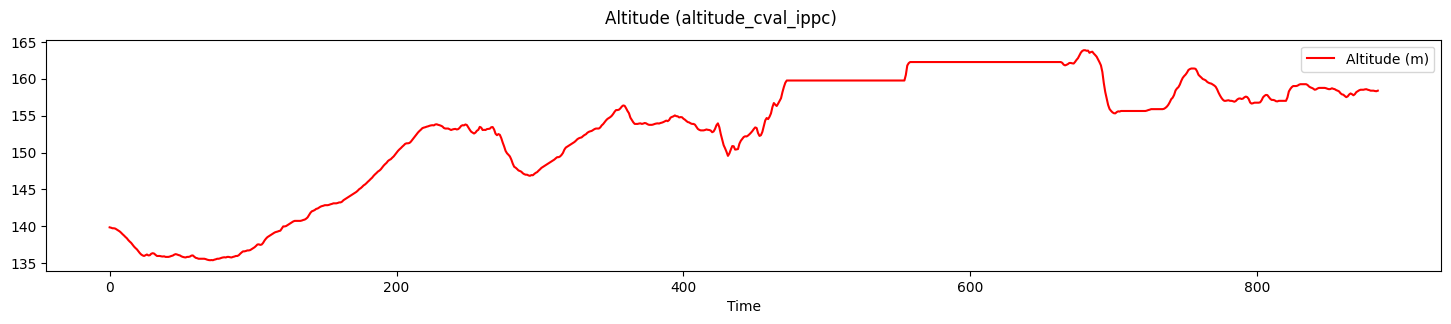

section 1
length: 1751
speed (start, end): (0.0, 0.0)


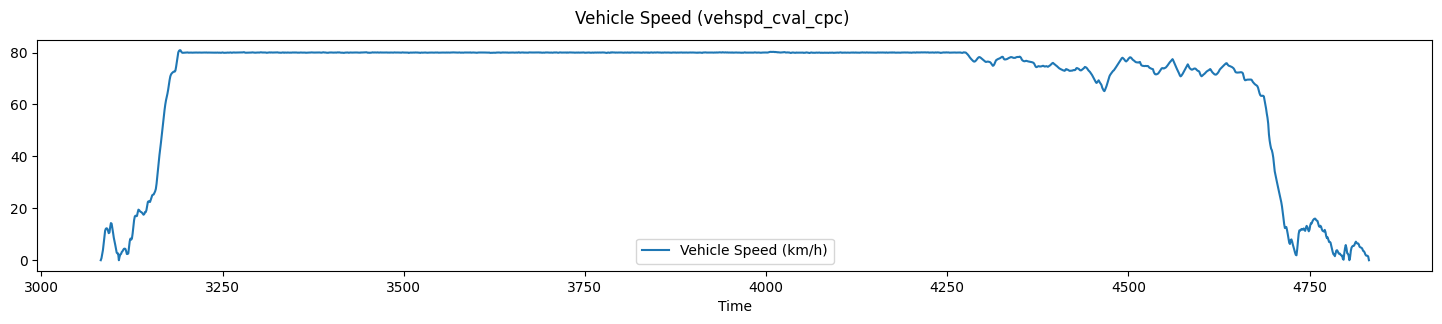

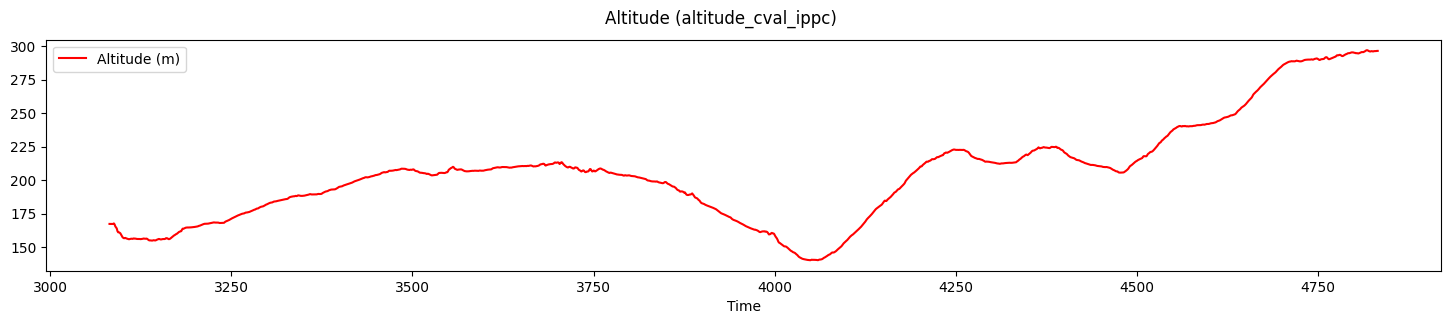

section 2
length: 10205
speed (start, end): (0.0, 0.0)


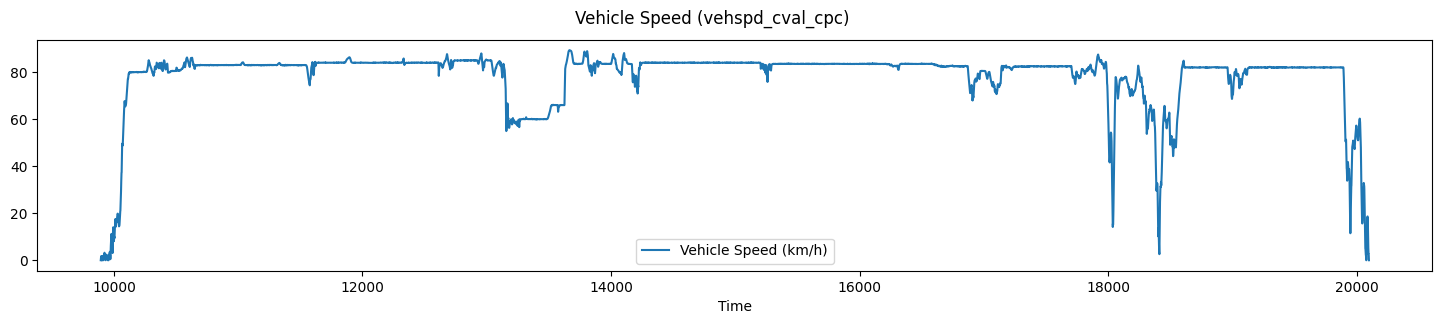

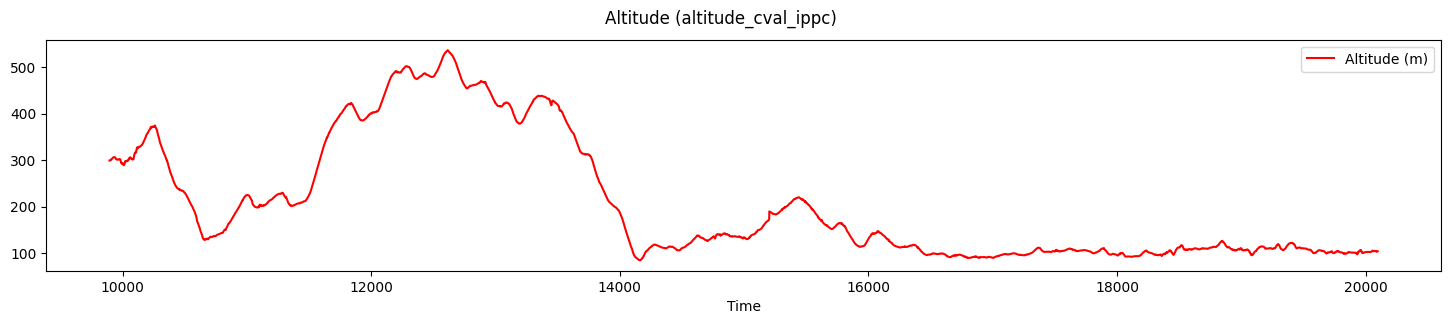

section 3
length: 128
speed (start, end): (0.0, 0.0)


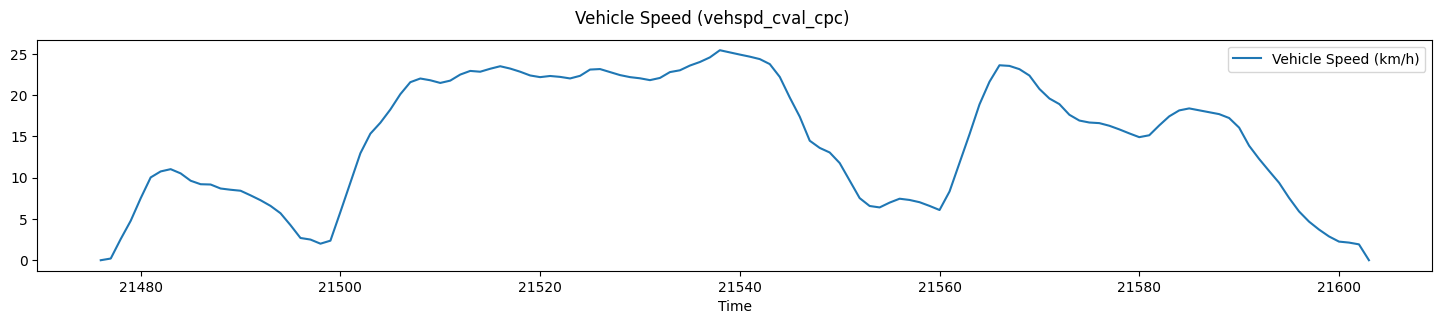

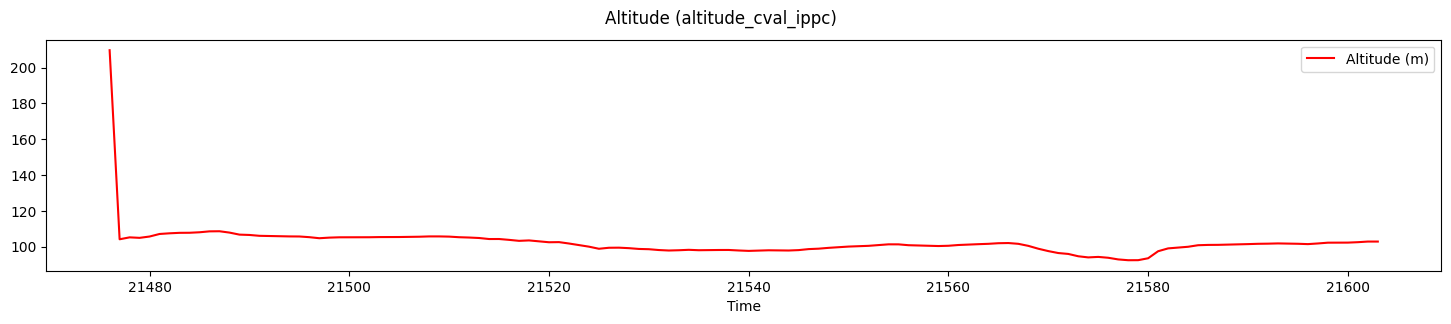

section 4
length: 61
speed (start, end): (17.658203125, 18.05)


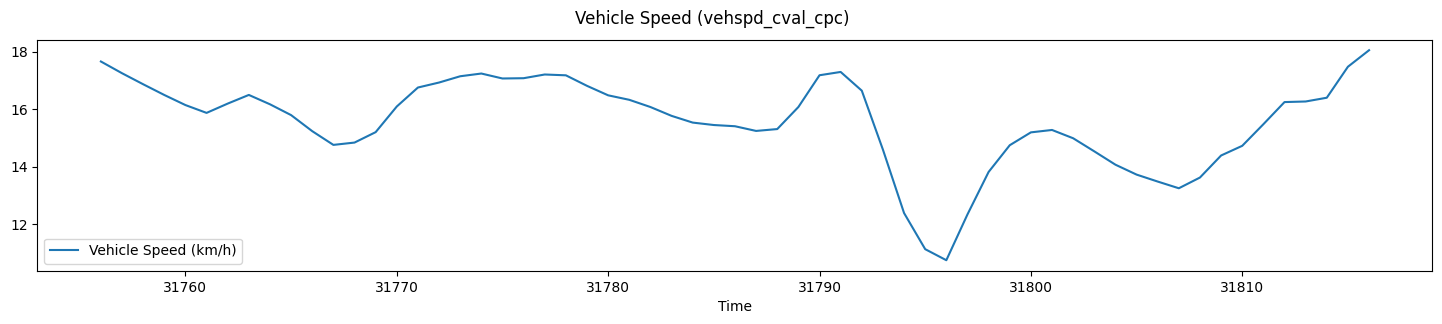

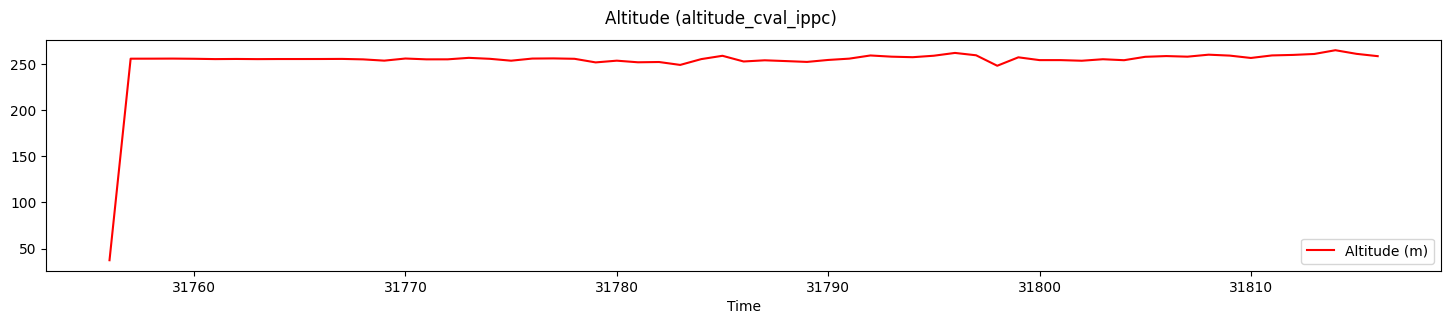

section 5
length: 920
speed (start, end): (0.0, 0.0)


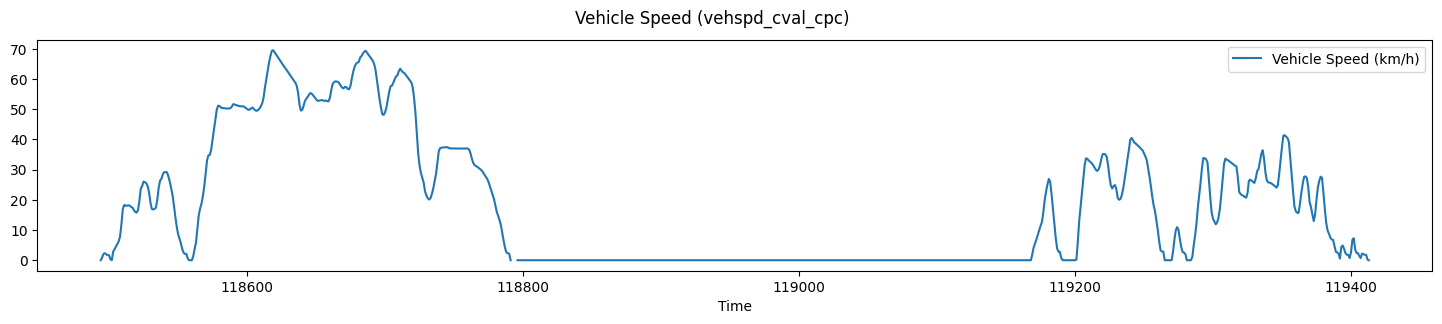

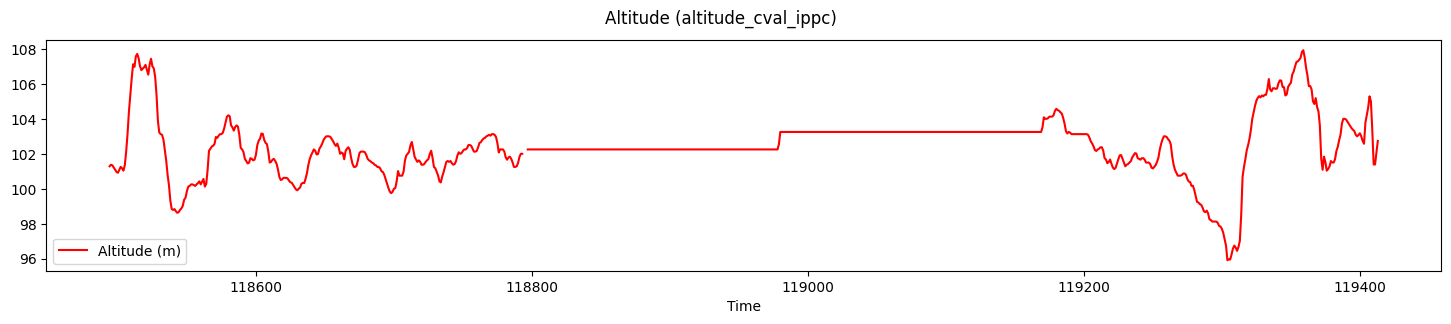

section 6
length: 481
speed (start, end): (0.0, 0.0)


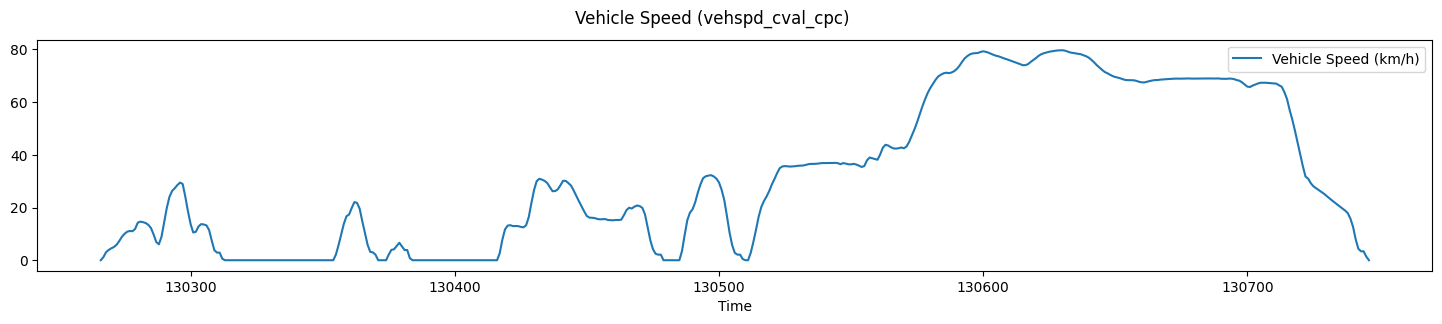

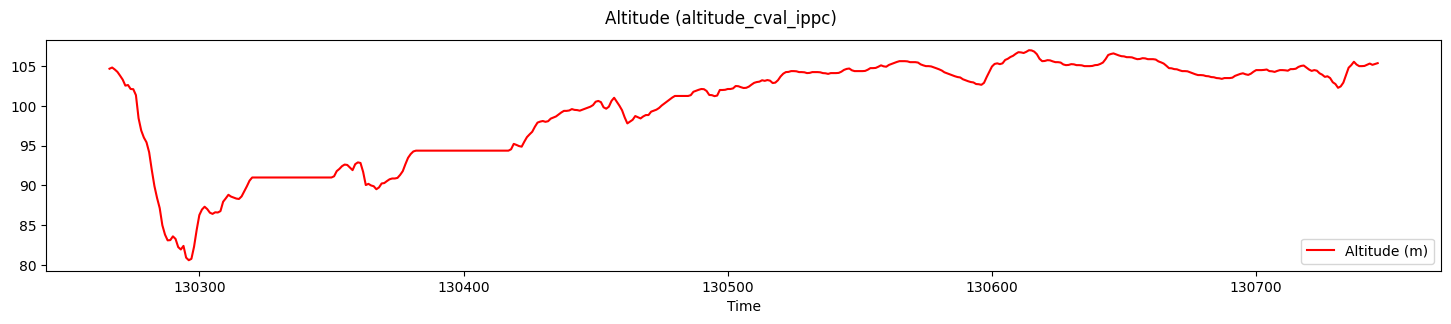

section 7
length: 882
speed (start, end): (0.0, 0.0)


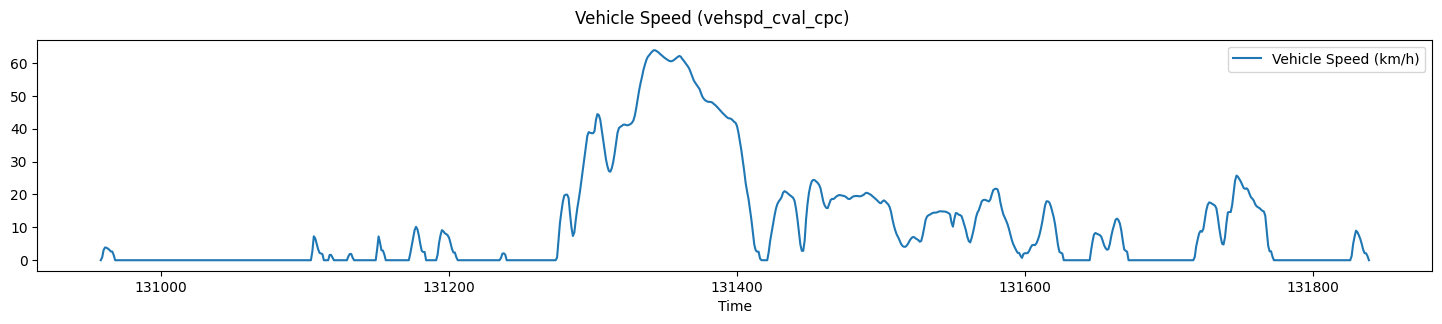

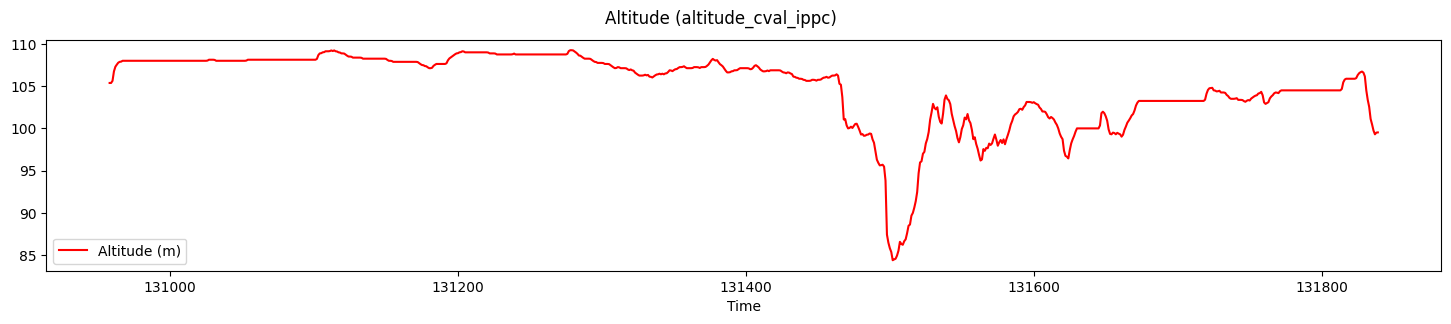

section 8
length: 285
speed (start, end): (0.0, 0.0)


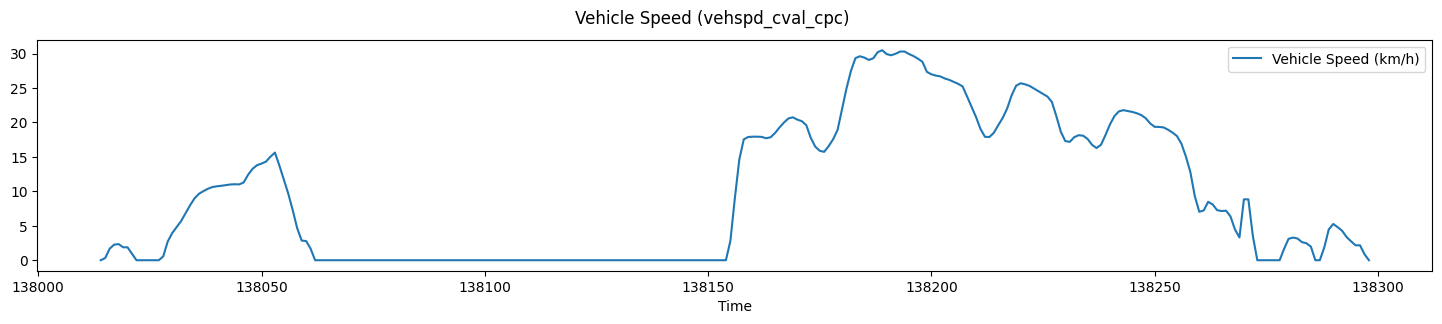

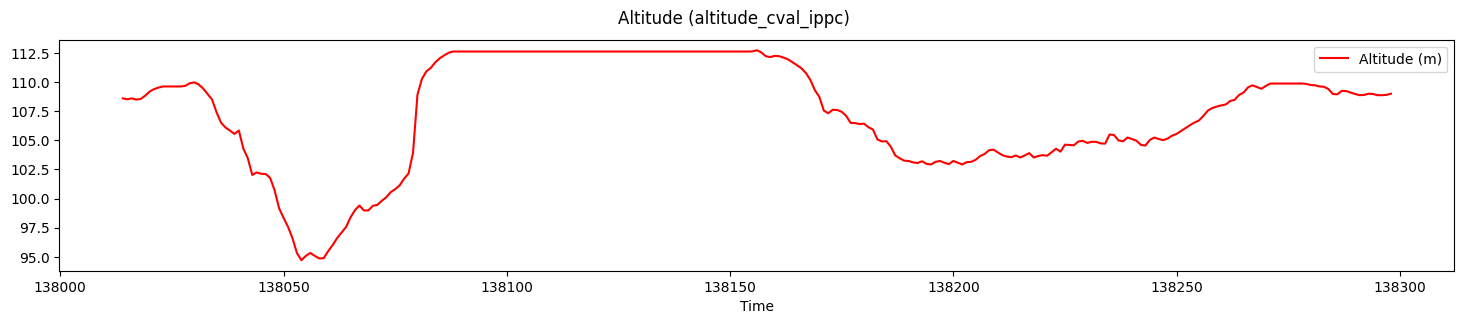

section 9
length: 65
speed (start, end): (21.713671875, 0.0)


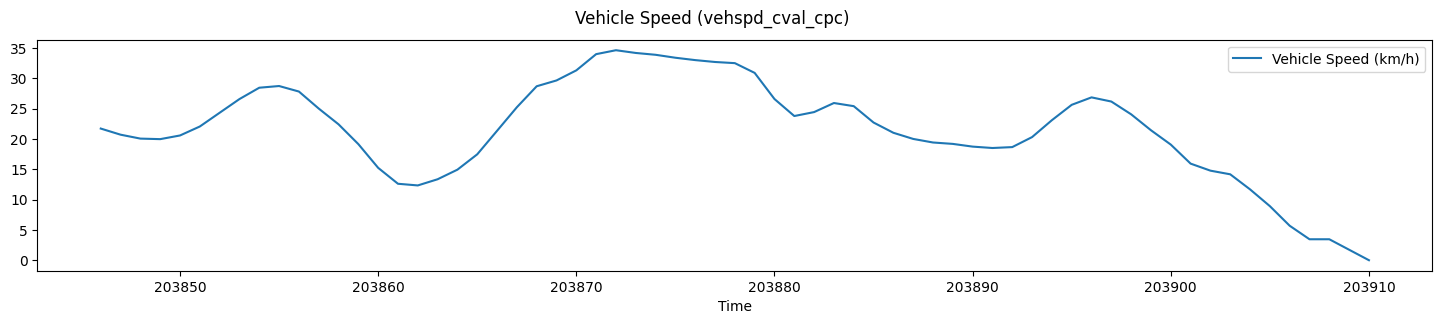

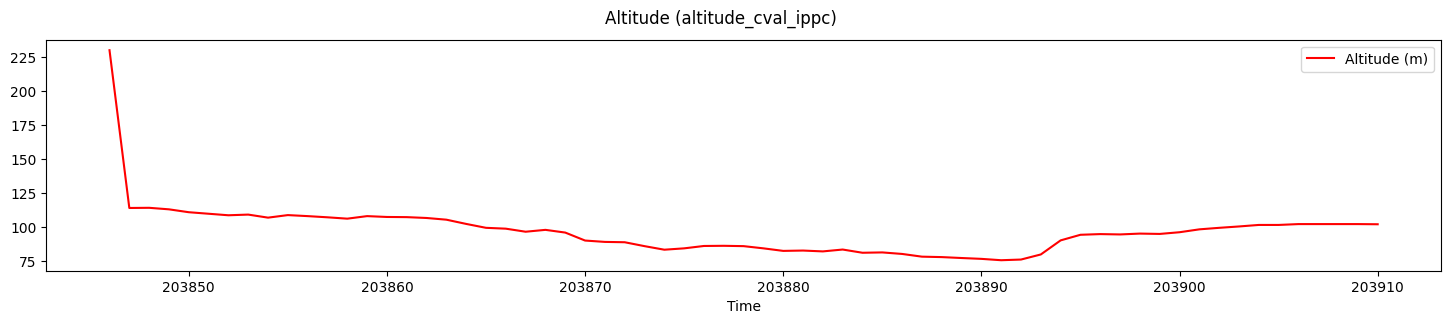

section 10
length: 73
speed (start, end): (0.0, 0.0)


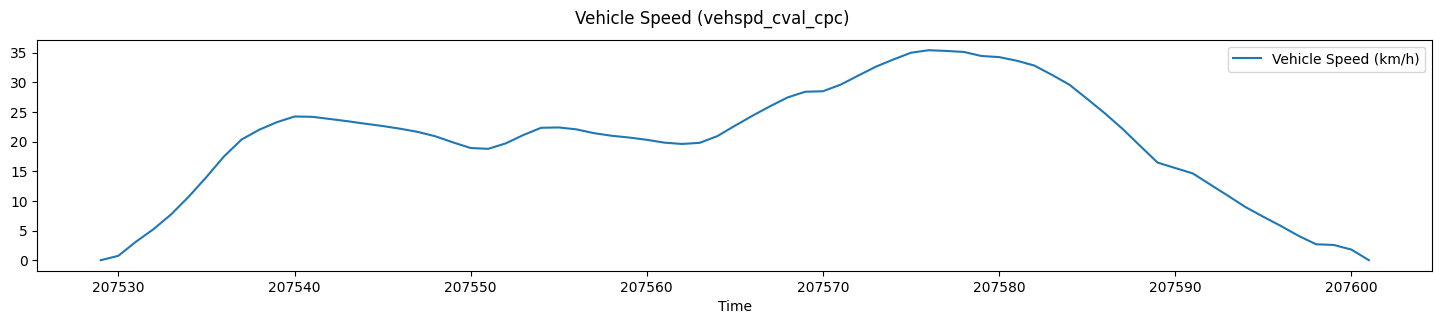

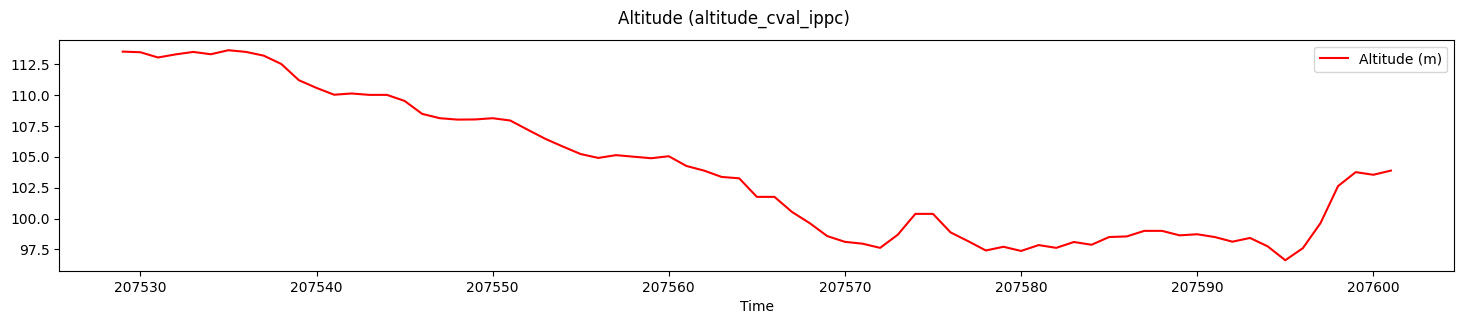

section 11
length: 148
speed (start, end): (0.0, 0.0)


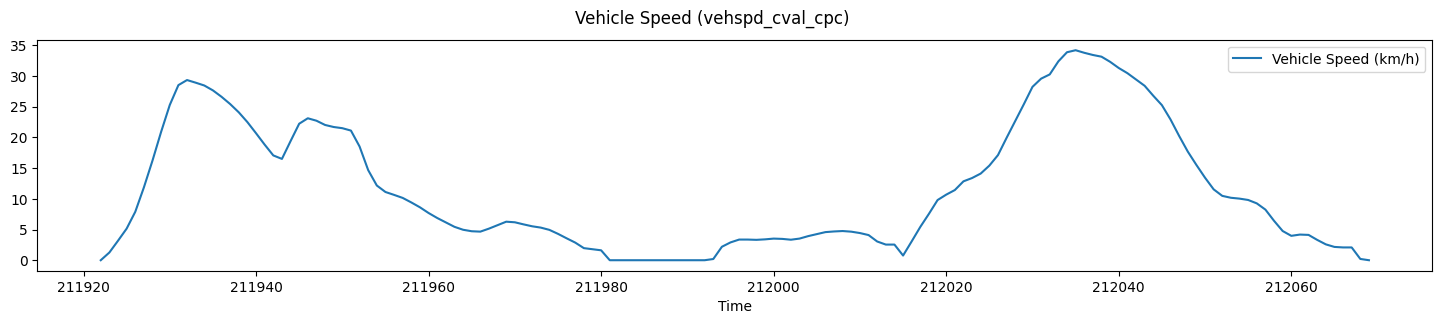

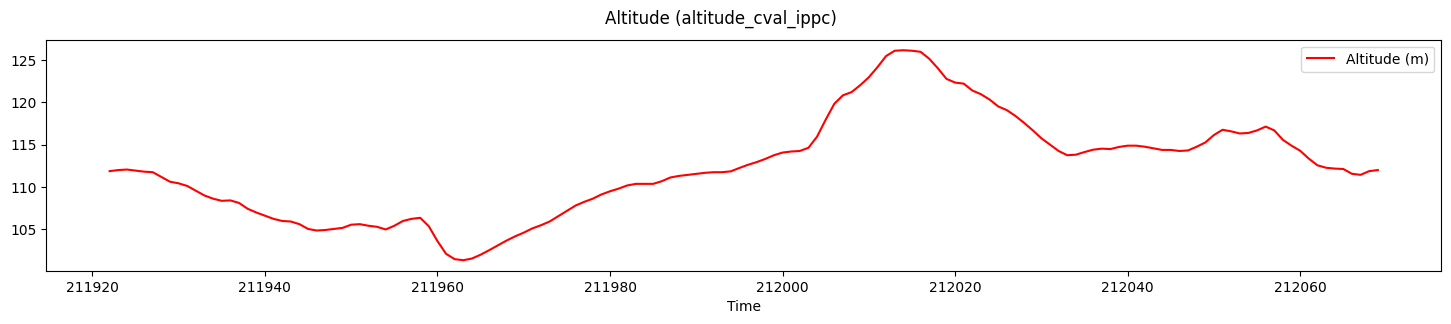

In [ ]:
# PLOT EACH SECTION FROM ABOVE IN DETAIL AND SEPERATELY ---------------------------------------------------------------
for n, s in enumerate(sections):
    print(f"section {n}")
    print(f"length: {s.stop - s.start}")
    print(f"speed (start, end): {(v[s].iloc[0], v[s].iloc[-1])}")
    
    v[s].plot(figsize=(18, 3), subplots=True, title='Vehicle Speed (vehspd_cval_cpc)')
    plt.legend(['Vehicle Speed (km/h)']); plt.xlabel('Time'); plt.show()

    alt[s].plot(figsize=(18, 3), subplots=True, color='red', title='Altitude (altitude_cval_ippc)')
    plt.legend(['Altitude (m)']); plt.xlabel('Time'); plt.show()